(sec:q-learning)=
# SARSAとQ学習

ここまでで扱った多腕バンディット問題は、取れる行動の種類が少なく、また、問題の状態が変化しない、すなわち、いつスロットを回しても、各アームの当たり確率は変化しない、という特徴があった。

しかし、実際の問題は取れるべき行動の種類が多く(場合によっては連続変数)、また、ある時刻で取った行動により、行動を行う対象の状態が変化するのが一般的である。

このような状況において用いられる強化学習の手法に**TD学習**と呼ばれる学習法がある。TD学習のTDとはTemporal Differenceのことで、実際に行動を取りながら、どのような方策で行動を取るべきかを表す**行動価値関数**を更新していく手法である。

TD学習の代表的な手法には**SARSA** (state-action-reward-state-action)と**Q学習**がある。Q学習のQとは**行動価値関数**を表すQ値のQである。

この両者において、行動価値関数$Q$は、とある**状態**$s$ (stateのs)において取った**行動**$a$ (actionのa)の価値を関数として、$Q(s, a)$のように表す。

In [1]:
"""
Google Colabの準備
"""

IN_COLAB = True
try:
    import google.colab

    print("You are running the code in Google Colab.")
except ImportError:
    IN_COLAB = False
    print("You are running the code on the local computer.")

if IN_COLAB:
    # Gymnasiumのインストール
    !pip install torch torchvision
    !pip install "gymnasium[classic-control]"
    pass

You are running the code on the local computer.


In [ ]:
import random

import numpy as np
import seaborn as sns
import IPython.display as display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib.animation import ArtistAnimation

try:
    from myst_nb import glue
except ImportError:
    glue = lambda *args, **kwargs: None

# パラメータ
n_episodes = 10000
glue("n_episodes", n_episodes)

# 乱数のシードを固定
random.seed(31415)
np.random.seed(31415)

# グラフの設定
rc = {
    "figure.dpi": 150,
    "axes.linewidth": 1,
    "axes.edgecolor": "black",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "legend.frameon": True,
    "legend.borderpad": 0.5,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.framealpha": 1.0,
}
sns.set_theme(style="whitegrid", palette="colorblind", rc=rc)

10000

## Markov決定過程

SARSAやQ学習で扱う対象は**Markov決定過程**と呼ばれる状態遷移のモデルである。

Markov決定過程をかみ砕いて言えば、その時々で取った行動により次の状態が変化するが、それより過去に取った行動がその状態の変化に影響を与えることはない、という性質 (この性質を**Markov性**と呼ぶ)を満たす状態遷移のモデルである。

Markov性を満たす状態遷移であれば、とある状態$s$において、行動を$a$取ったときに、別の状態$s'$に移る確率は$s, a$だけに関する事後確率として$P(s' | s, a)$のように書ける。

ここで、事後分布$P(s' | s, a)$を用いて、行動評価関数$Q(s, a)$が以下の**Bellmanの最適性公式**を満たすと仮定する。


:::{admonition} Bellmanの最適性公式
:class: note

$$
Q(s, a) = R(s, a) + \gamma \sum_{a' \in \mathcal{A}} P(s' | s, a) Q(s', a')
$$ (eq:bellman-equation)

:::


この式において$\gamma$は**割引因子** (discount factor)と呼ばれる値で、$0 < \gamma < 1$であり、$R(s, a)$は状態$s$において行動$a$を取ったときに即座に得られる報酬を表す。

{eq}`eq:bellman-equation`は、**最適な行動価値関数が、その時、即座に得られる報酬$R(s, a)$と未来の行動から得られる報酬に一定の減衰を加えたものの和として表せる**ことを示している。

一方、多くの状態遷移のモデルでは、状態遷移は確率的なものではなく、行動$a$の結果として**一意に次の状態が決まる**ことが多い。

そこで$P(s' | s, a) = 1$と仮定する。さらに、仮に理想的なQ関数が求まっているのであれば、$s'$において行動価値が最大になる行動$a'$をQ関数から決定できるので、$a'$は行動価値が最大になるものであると仮定する。

これら2つの仮定により、{eq}`eq:bellman-equation`は、以下の形で書き直せる。

$$
Q(s, a) = R(s, a) + \gamma \max_{a' \in \mathcal{A}} Q(s', a')
$$ (eq:bellman-equation-2)

これから紹介するSASRAやQ学習は、{eq}`eq:bellman-equation-2`を満たすような$Q(s, a)$を強化学習の枠組みによって求めるものである。

## TD学習のアルゴリズム

SARSAを始めとするTD学習法は、実際の環境において、適当な行動を取ったときに得られる報酬と状態遷移から、{eq}`eq:bellman-equation-2`の両辺の差が小さくなるように$Q(s, a)$の値を更新する。

典型的な実装では、$s$と$a$を離散化して、$Q(s, a)$を二次元配列として扱う。このような離散化された行動価値関数を**Qテーブル**と呼ぶ。

Qテーブルの更新は現在の$Q(s, a)$の値 (学習途中は必ずしも{eq}`eq:bellman-equation-2`を満たしていないことに注意)を{eq}`eq:bellman-equation-2`の右辺に近づくように更新する。

具体的には、学習率$0 < \alpha < 1$を用いて、以下の式で$Q(s, a)$を更新する。

$$
Q_{\rm new}(s, a) = (1 - \alpha) Q(s, a) + \alpha \left[ R(s, a) + \gamma \max_{a'} Q(s', a') \right]
$$

また、この式は以下の形で書き直すことができる。

$$
Q_{\rm new}(s, a) = Q(s,a ) + \alpha \left[ R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$ (eq:q-update)

{eq}`eq:q-update`の右辺における以下の部分は**TD誤差** (temporal difference error)と呼ばれる。TD学習は、このTD誤差を最小化する問題であると言い換えられる。

:::{admonition} TD誤差
:class: note

$$
R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a)
$$

:::

なお、SARSAを用いる場合もQ学習を用いる場合も、エピソード終了時にはそれ以後の行動価値を考える必要がないため、TD誤差は $R(s, a) - Q(s,a)$ のようなシンプルな形で書けることに注意してほしい。

### SARSA

前述の{eq}`eq:q-update`における行動価値関数$Q$は、Bellmanの最適性公式を満たす**理想的な行動価値関数**であった。

しかし、これは一般には未知であるため、強化学習の枠組みの中で最適化していなければならない。

SARSAは、行動価値が最大の行動を取る代わりに、$\varepsilon$-greedy法やソフトマックス探索などの方法で行動を選択し、その行動に基づいて行動価値関数を更新する。

すなわち、SARSAで用いるQテーブルの更新式は以下のように表せる。

$$
Q_{\rm new}(s, a) = Q(s, a) + \alpha \left[ R(s, a) + \gamma Q(s', a') - Q(s, a) \right]
$$

言い換えると、SARSAでは、ある状態 $s$ において行動 $a$ を取った結果の状態 $s'$ において、更に行動 $a'$ を取ったとして、Qテーブルを更新する。

上記の更新式には$s$, $a$, $R$, $s'$, $a'$が現れるので、その頭文字を取って、このような更新則を用いる手法をSARSAと呼ぶ。

### Q学習

SARSAの説明の中では最適な行動価値関数は事前には分かっていない、と説明した。

Q学習は、その事前に分からない行動価値関数を適当な形で初期化して、それが最適な行動価値関数だと仮定して行動を行ない、関数の更新を行う。

従って、Q学習で用いる更新則は{eq}`eq:q-update`そのままとなる。

しかも、Q学習は更新過程にあるQテーブルが最適な行動価値関数だと考えているので、$\varepsilon$-greedy法やソフトマックス探索のような**方策決定法を別途用いる必要が無い**というのが重要な性質である。

## 倒立振子のバランシング

TD学習法を実際に試すために、比較的単純な倒立振子のバランスを取るゲームについて考える。倒立振子のシミュレータは[Gymnasium](https://gymnasium.farama.org/)というライブラリ(旧名: OpenAI Gym)から簡単に使用することができる。

GymnasiumはPipを用いてインストールできる。以下の実験で使用する倒立振子のシミュレータは`classic-control`というカテゴリのモジュール群に含まれるので、以下のようにオプションを指定してGymnasiumをインストールすると良い。

```shell
pip install "gymnasium[classic-control]"
```


モジュール`gymnasium`をインポート後 (`gym`とエイリアスをつける)、`gym.make`関数を用いてゲーム環境`env`を作成してみる。

`gym.make`関数に倒立振子のゲーム環境である`CartPole-v1`を指定し、`render_mode`パラメータに`rbg_array`を指定する。

このように`render_mode`を指定しておくと、`env.render`関数によって画面の情報をNumPyの配列として得ることができるので、Matplotlibを用いて、初期状態を描画してみる。

In [ ]:
import gymnasium as gym

# ゲーム環境の作成
env = gym.make("CartPole-v1", render_mode="rgb_array")

# ゲーム環境のリセット
obsrv = env.reset(seed=31415)

# 現在の状態をRGB画像として取得する
img = env.render()

最終行の`env.render()`で得られた画像を表示すると次のようになる。

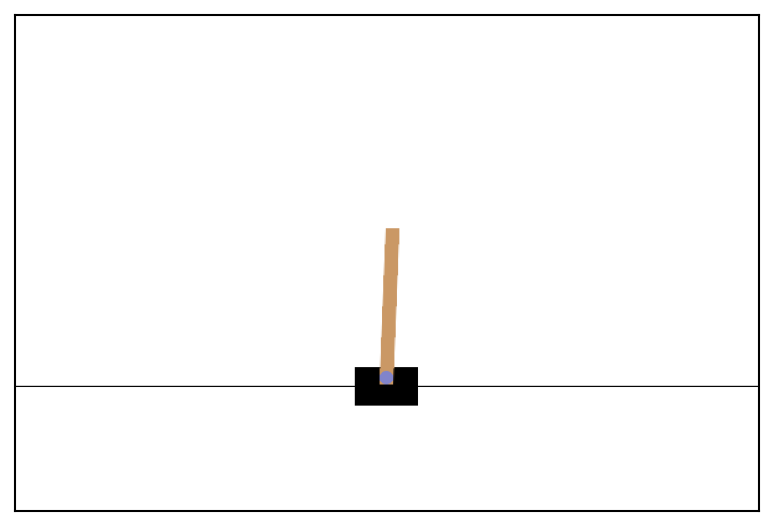

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.set(xticks=[], yticks=[])

glue("cartpole_init_state", fig)
plt.close()

:::{glue:figure} cartpole_init_state
:figclass: image-stylish
:::

このように、CartPoleは台車 (cart)の上に倒立振子 (pole)が取り付けられたものを制御して、できる限り長い時間、振子が倒れないようにバランスを取るゲームである。

倒立振子は、その状態を表すいくつかのパラメータを持っており、それが`reset`関数の戻り値として取得される`obsrv`の中に格納されている。

`obsrv`は`tuple`型の変数になっていて、CartPole環境の場合には**第1要素に状態を表す変数が入っている**。

In [ ]:
# 現在の状態変数を確認
print(obsrv[0])

[-3.1067048e-05 -3.8479745e-02  3.6217723e-02  3.3740070e-02]


CartPole環境の場合は、4つの浮動小数が格納されており、先頭から、
- 台車の水平位置
- 台車の速度
- 振子の角度
- 振子の角速度
をそれぞれ表している。

また、それぞれの値が取る範囲は以下のようになっている [[参考URL]](https://gymnasium.farama.org/environments/classic_control/cart_pole/)。

|Num|Observation|Min|Max|
|---|---|---|---|
| 0 | 台車の位置 | -4.8 | +4.8 |
| 1 | 台車の速度 | -Inf | +Inf |
| 2 | 振子の角度 | -24° | +24° |
| 3 | 振子の角速度 | -Inf | +Inf |

この値は、`env`の`observation_space`フィールドで確認することができる。

CartPole環境の場合には`observation_space`は`Box`という型で表されていて、`low`、`high`というフィールドにパラメータの最小値、最大値が格納されている。

In [ ]:
print(f"Lower bound: {env.observation_space.low}")
print(f"Upper bound: {env.observation_space.high}")

Lower bound: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Upper bound: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


Gyminasiumのゲーム環境には、この他にも多数の関数が用意されており、それを強化学習に用いることができる。

### ランダムな行動選択


まずは、その挙動を理解するために、ランダムに行動を選んだ場合にどのような動きになるのかを確認してみよう。

ランダムな行動選択には、`env.action_space.sample()`を使うことができる。CartPole環境の場合には`env.action_space.n`に格納されているとおり、取り得る行動は **0: 左に移動**, **1: 右に移動** の2つだけなので、`sample`関数はこのうちの一方をランダムに返してくる。

In [ ]:
# ランダムに5回行動選択をしてみる
for i in range(5):
    print(env.action_space.sample())

1
1
1
0
0


選んだ行動をとって状態を更新するには`env.step`関数を用いる。`step`関数の引数に行動を表す整数を与えることで状態が更新される。

`step`関数もまた`reset`関数と同様に`tuple`型の変数を返してくる。ここには`reset`関数の時よりも多くの情報が含まれていて、

- **第1要素:** 現在の状態を表すパラメータ (上記の`obsrv`と同様)
- **第2要素:** 行動により直接得られた報酬
- **第3要素:** エピソードが終了したかどうか (ゲームオーバーになったかどうか)
- **第4要素:** 行動を表すパラメータが範囲外に外れたかどうか (今回は使用しない)
- **第5要素:** その他の追加情報 (今回は使用しない)

のような構成となっている。

In [ ]:
obsrv, reward, done, _, _ = env.step(0)
print("Observation:", obsrv)
print("Reward:", reward)
print("Finished?:", done)

Observation: [-0.00080066 -0.23410185  0.03689252  0.3376265 ]
Reward: 1.0
Finished?: False


これらを用いてランダムに行動選択をし、その時々の状態を画像として格納する。

In [ ]:
# ゲーム環境のリセット
obsrv, _ = env.reset()
frames = []

# ゲームループ
while True:
    # 現在の画面を画像として保存
    img = env.render()
    frames.append(img)

    # ランダムに行動選択
    a = env.action_space.sample()

    # 状態を更新する
    obsrv, reward, done, _, _ = env.step(a)

    # もしゲームが終了していたらループを抜ける
    if done:
        break

In [ ]:
# アニメーションの描画
fig, ax = plt.subplots()
ax.set(xticks=[], yticks=[])

# 各フレームの描画
draw = []
for i, f in enumerate(frames):
    ims = plt.imshow(f)
    txt = plt.text(20, 30, f"frame #{i+1:d}")
    draw.append([ims, txt])
    fig.tight_layout()

# アニメーションの作成
ani = ArtistAnimation(fig, draw, interval=100, blit=True)
html = display.HTML(ani.to_jshtml())
display.display(html)

# Matplotlibのウィンドウを閉じる
plt.close()

このようにランダムに行動した場合には、途中で棒の傾きが一定以上になってしまい、エピソードが終了していることが分かる。

以下では、Q学習によって行動評価関数を最適化し、より長い時間、倒立状態を保てるようにしてみよう。

### Qテーブルを使う準備

まずはQテーブルを作成するために、4種類のパラメータを離散化しておこう。以下の例では、**速度と各速度の範囲を適当に狭めておき、その上で各パラメータの取り得る範囲を8分割する**

In [ ]:
N_INPUTS = env.observation_space.shape[0]  # 状態を表す変数の数
N_ACTIONS = env.action_space.n  # 取れる行動の数
N_DIGITS = 8  # 各パラメータを何段階で量子化するか

lower = env.observation_space.low
upper = env.observation_space.high
lower[1], upper[1] = -5.0, 5.0  # 速度の範囲を修正
lower[3], upper[3] = -0.5 * np.pi, 0.5 * np.pi  # 角速度の範囲を修正

今回の倒立振子の例ではパラメータ4つを8分割しているので、取り得る離散状態の組み合わせは$8^4 = 4096$通りである。取り得る行動は左に行くか、右に行くかの2種類であるので、結局、Qテーブルのサイズは$4096 \times 2$となる。

In [ ]:
# Q値テーブルの初期化 (乱数による初期化)
q_table = np.random.random(size=(N_DIGITS**N_INPUTS, env.action_space.n))

8分割されたパラメータの範囲を求めるには`np.linspace`関数が使える。この関数はこれまで第1, 第2引数にスカラー値を入力して使ってきたが、サイズが同じであれば配列を指定することもできる。

In [ ]:
bins = np.transpose(np.linspace(lower, upper, N_DIGITS))
print("Cart position:\n", bins[0])
print("Cart velocity:\n", bins[1])
print("Pole angle:\n", bins[2])
print("Pole angular velocity:\n", bins[3])

Cart position:
 [-4.8        -3.4285717  -2.057143   -0.68571424  0.68571424  2.0571427
  3.4285717   4.8       ]
Cart velocity:
 [-5.         -3.5714285  -2.142857   -0.71428585  0.71428585  2.1428576
  3.5714283   5.        ]
Pole angle:
 [-0.41887903 -0.2991993  -0.17951958 -0.05983984  0.05983987  0.1795196
  0.29919934  0.41887903]
Pole angular velocity:
 [-1.5707964  -1.1219974  -0.67319846 -0.22439945  0.22439945  0.67319834
  1.1219975   1.5707964 ]


今、とある状態変数が与えられた時に、それが4096個の離散状態のどれに対応するのかを定めておく必要がある。

これには、4つあるパラメータのそれぞれが8個の範囲のどれに入るのかを求めて、その値を元に状態を表わす整数を計算する必要がある。

各パラメータが8つの範囲のどれに属するかを求めるには`np.digitize`関数が使える。4つのパラメータのそれぞれについて、リスト内包表記によって所属する範囲のインデックスを求めるとすれば、以下のようなコードになる。

In [ ]:
obsrv, _ = env.reset()
digits = [np.digitize(o, b) for o, b in zip(obsrv, bins)]
print(digits)

[4, 4, 4, 4]


現在は各パラメータの範囲を8つに分割しているので、`digits`には0-7の整数が与えられる。従って、この数字を8進数であると考えて、10進数表記に直せば、各離散状態に対して重複のない整数のインデックスを付与することができる。

このような計算は、単純には以下のようなfor文を用いたコードで実現できる。

In [ ]:
index = 0
for n in digits:
    index = index * N_DIGITS + n
print(index)

2340


もう少しPythonらしい書き方にするのであれば、`functools.reduce`関数を用いて以下のように書くこともできる。

In [ ]:
from functools import reduce

index = reduce(lambda a, b: a * N_DIGITS + b, digits)
print(index)

2340


これらを踏まえて、状態を表わすインデックスを計算するコードを関数化しておく。

In [ ]:
def to_state_index(obsrv, bins):
    digits = [np.digitize(o, b) for o, b in zip(obsrv, bins)]
    return reduce(lambda a, b: a * N_DIGITS + b, digits)

また、以下の実験で用いるTD学習のハイパー・パラメータは次のように設定しておく。

In [ ]:
alpha = 0.1  # 学習率
gamma = 0.99  # 割引率

### SARSAによるQテーブルの最適化

では、ここまでの下準備を元に、ソフトマックス探索により行動を決定しながらSARSAによるQテーブルの最適化を実施する。

ソフトマックス探索に用いるBoltzmann関数は{ref}`sec:reinforcement-learning`で用いたものと同様である。

In [ ]:
def boltzmann(x, tau=1.0):
    x = x / tau
    x -= np.max(x)
    e = np.exp(x)
    return e / np.sum(e)

Qテーブルは0から1の間の乱数で初期化し、{glue:}`n_episodes`エピソード分のプレイを行ないながらSARSAによりQテーブルを更新する。

In [ ]:
# Q値テーブルの初期化
q_table = np.random.random(size=(N_DIGITS**N_INPUTS, env.action_space.n))

# エピソードのループ
for epi in tqdm(range(n_episodes)):
    # ゲーム環境のリセット
    obsrv, _ = env.reset()

    # エピソード開始
    s0, a0, done = -1, -1, False
    while True:
        # ソフトマックス探索による行動選択
        s1 = to_state_index(obsrv, bins)
        probs = boltzmann(q_table[s1, :])
        a1 = np.random.choice(env.action_space.n, p=probs)

        # Qテーブルの更新
        if s0 >= 0 and a0 >= 0:
            q0 = q_table[s0, a0]
            q1 = q_table[s1, a1]
            q_table[s0, a0] = (1.0 - alpha) * q0 + alpha * (reward + gamma * q1 * (1.0 - done))

        # 状態の更新
        obsrv, reward, done, _, _ = env.step(a1)

        # 過去の状態と行動を記録
        s0, a0 = s1, a1

        if done:
            break

  0%|          | 0/10000 [00:00<?, ?it/s]

Qテーブルの最適化が終了したら、実行フェーズにおいては、常にQテーブルに基づいて最適な行動を取ることとする。

状態の画像を保存しつつ、学習結果に基づいて行動をするコードは以下の通りである。

In [ ]:
frames = []
obsrv, _ = env.reset()
while True:
    img = env.render()
    frames.append(img)

    # 最もQ値の高い行動を選択
    s = to_state_index(obsrv, bins)
    a = np.argmax(q_table[s, :])

    obsrv, reward, done, _, _ = env.step(a)
    if done:
        break

上記のコードで得られた`frames`を可視化すると次のようになる。

In [ ]:
# アニメーションの描画
fig, ax = plt.subplots()
ax.set(xticks=[], yticks=[])

# 各フレームの描画
draw = []
for i, f in enumerate(frames):
    ims = plt.imshow(f)
    txt = plt.text(20, 30, f"frame #{i+1:d}")
    draw.append([ims, txt])
    fig.tight_layout()

# アニメーションの作成
ani = ArtistAnimation(fig, draw, interval=100, blit=True)
html = display.HTML(ani.to_jshtml())
display.display(html)

# Matplotlibのウィンドウを閉じる
plt.close()

このようにSARSAを用いたQテーブルの更新により、倒立振子を長時間に渡り倒立状態で保つことができている。

::::{admonition} 問
:class: question

SARSAにおいて、ソフトマックス探索の部分をUCB1値や他の評価指標を用いた探索に置き換えて、学習の性能がどのように変化するかを調べよ。

::::

### Q学習によるQテーブルの最適化

前述の通り、SARSAは次の行動を決定するために、ソフトマックス探索のような行動決定法を別途用いる必要があった。

一方、Q学習においては、任意の状態において、現在求まっているQテーブルの値をから、行動価値が最大の行動を取り、その結果に基づいてQテーブルを更新する。

従って、次の行動`a0`を得るアルゴリズムは以下のようなシンプルなものになる。

```python
# 一番価値が高く見積もられている行動をとる
# この際、特定の行動選択方策を使っていない
s0 = to_state_index(obsrv, bins)
a0 = np.argmax(q_table[s0, :])
obsrv, reward, done, _, _ = env.step(a0)
```

In [ ]:
# Q値テーブルの初期化
q_table = np.random.random(size=(N_DIGITS**N_INPUTS, env.action_space.n))

for epi in tqdm(range(n_episodes)):
    # ゲーム環境のリセット
    obsrv, _ = env.reset()

    # エピソード開始
    while True:
        # 現在の状態に対応する行番号を計算
        s0 = to_state_index(obsrv, bins)
        a0 = np.argmax(q_table[s0, :])

        # 状態の更新
        obsrv, reward, done, _, _ = env.step(a0)

        # 新たな状態に対する行番号を計算
        s1 = to_state_index(obsrv, bins)

        # Qテーブルの更新
        q0 = q_table[s0, a0]
        max_q1 = np.max(q_table[s1, :])
        if done:
            q_table[s0, a0] = (1.0 - alpha) * q0 + alpha * reward
        else:
            q_table[s0, a0] = (1.0 - alpha) * q0 + alpha * (reward + gamma * max_q1)

        if done:
            break

  0%|          | 0/10000 [00:00<?, ?it/s]

学習結果のテストはSARSAの時と同様に、Q値が最も高い行動を常に選択することとする。

In [ ]:
frames = []
obsrv, _ = env.reset()
while True:
    img = env.render()
    frames.append(img)

    # 最もQ値の高い行動を選択
    s = to_state_index(obsrv, bins)
    a = np.argmax(q_table[s, :])

    obsrv, reward, done, _, _ = env.step(a)
    if done:
        break

In [ ]:
# アニメーションの描画
fig, ax = plt.subplots()
ax.set(xticks=[], yticks=[])

# 各フレームの描画
draw = []
for i, f in enumerate(frames):
    ims = plt.imshow(f)
    txt = plt.text(20, 30, f"frame #{i+1:d}")
    draw.append([ims, txt])
    fig.tight_layout()

# アニメーションの作成
ani = ArtistAnimation(fig, draw, interval=100, blit=True)
html = display.HTML(ani.to_jshtml())
display.display(html)

# Matplotlibのウィンドウを閉じる
plt.close()

Q学習は、行動選択のために別途方策を用いる必要がないという点でSARSAと比べてシンプルなアルゴリズムでありながら、SARSAと同程度に長い時間、倒立状態をキープできている。

::::{admonition} 問
:class: question

CartPole環境は1フレームごとに報酬として常に1を返してくるが、この値を画面中央にCartがある場合に高い値になるように更新することで、できる限り画面の内側で振子を保つように学習方法を変更せよ。

::::